In [5]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.preprocessing import  StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
import copy

from scipy.spatial.distance import cdist

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

import warnings
warnings.filterwarnings('ignore')


import sys
try:
    sys.path.append(r'/home/tacuevas/github/ECE542_NCSU_projC')
except:
    sys.path.append(r'/home/tomas/github/ECE542_NCSU_projC')
from utils import *
import seaborn as sns
from sklearn.metrics import f1_score
import pickle
from pathlib import Path

In [2]:
## read data as a dictionary with each subject as a different key
## the sessions are included as a column in each dataframe
pathData = Path(r'/home/tomas/github/ECE542_NCSU_projC/TrainingData')
dctData = read_data(pathData)

Subject 1
  N sessions: 8
    Number of X files: 8
    Number of y files: 8
Subject 2
  N sessions: 5
    Number of X files: 5
    Number of y files: 5
Subject 3
  N sessions: 3
    Number of X files: 3
    Number of y files: 3
Subject 4
  N sessions: 2
    Number of X files: 2
    Number of y files: 2
Subject 5
  N sessions: 3
    Number of X files: 3
    Number of y files: 3
Subject 6
  N sessions: 3
    Number of X files: 3
    Number of y files: 3
Subject 7
  N sessions: 4
    Number of X files: 4
    Number of y files: 4
Subject 8
  N sessions: 1
    Number of X files: 1
    Number of y files: 1


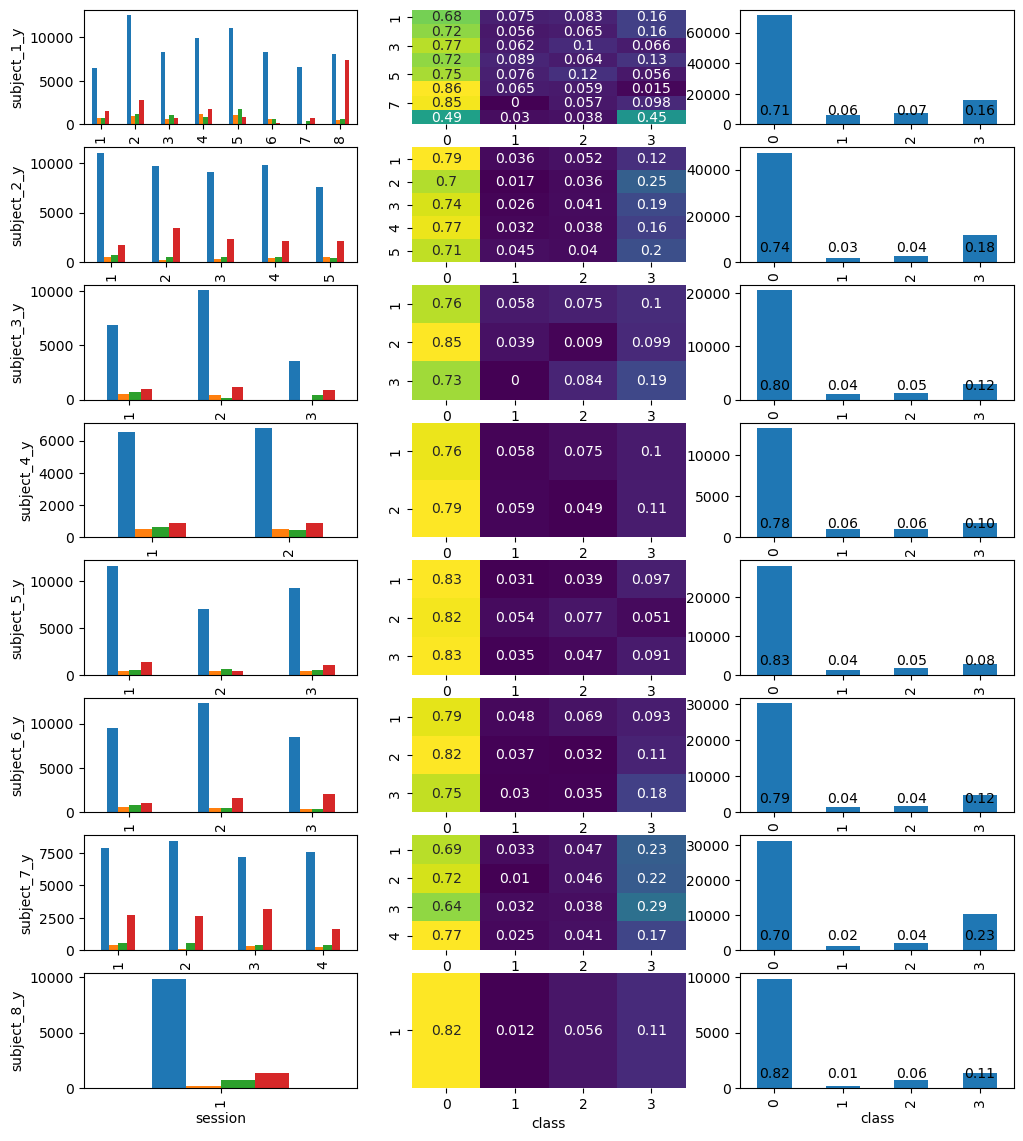

In [6]:
## Raw dataset
dctPerSess = {}
dctPerClass = {}

fig, ax = plt.subplots(figsize = (12, 14), nrows = 8, ncols = 3)
for ik, k in enumerate([x for x in dctData.keys() if x.endswith('_y')]):
    dfclass = dctData[k]
    table = pd.pivot_table(dctData[k], values='class', index='session', columns='class', aggfunc=len, fill_value=0)
    table.plot.bar(ax = ax[ik, 0], legend = False)
    
    perSess = table.copy()
    for i in perSess.index:
        perSess.loc[i, :] = perSess.loc[i, :].values/np.sum(perSess.loc[i, :].values)
    sns.heatmap(perSess, annot=True, cbar=False, cmap='viridis', ax = ax[ik, 1])
    ax[ik, 1].set_ylabel('')

    dctPerSess[k] = perSess
    dctPerClass[k] = table.sum(axis = 0)/table.sum().sum()

    # Add annotations
    table.sum().plot.bar(ax = ax[ik, 2], legend = False)
    for iv, v in enumerate(dctPerClass[k]):
        ax[ik, 2].annotate(f"{v:.2f}", xy=(iv, 0), xytext=(0, 5), textcoords="offset points", 
                        ha='center', va='bottom', fontsize=10)

    ax[ik, 0].set_ylabel(k)


In [7]:
## count ocurrence of each class per subject and session
dctCountRaw = {f'subject_{k+1}':pd.DataFrame(index = range(1, 9), columns = range(0, 4), data = 0) for k in range(8)}
for ik, k in enumerate([x for x in dctData.keys() if x.endswith('_y')]):
    dfs = dctData[k]
    for s in dfs['session'].unique():
        dfss = dfs[dfs['session'] == s]
        aux = dfss['class'].value_counts().sort_index()
        dctCountRaw[k[:-2]].loc[s, aux.index] = aux.values

In [3]:
## upsample labels using nearest neighbor
dctUps = upsampleData(dctData)
# with open(r'/home/tomas/Insync/tacuevas@ncsu.edu/Google Drive/NCSU/courses/ECE542/projC/upsampledDataset.pkl', 'rb') as fin:
#     dctUps = pickle.load(fin)

subject 1
  upsampling session 1
    len X: 37890
    len y: 9473
    len data: 37890
  upsampling session 2
    len X: 70172
    len y: 17543
    len data: 70172
  upsampling session 3
    len X: 43146
    len y: 10787
    len data: 43146
  upsampling session 4
    len X: 54956
    len y: 13739
    len data: 54956
  upsampling session 5
    len X: 59121
    len y: 14780
    len data: 59121
  upsampling session 6
    len X: 38631
    len y: 9658
    len data: 38631
  upsampling session 7
    len X: 31423
    len y: 7856
    len data: 31423
  upsampling session 8
    len X: 66762
    len y: 16691
    len data: 66762
    len total data subject 1: 402101
subject 2
  upsampling session 1
    len X: 55999
    len y: 14000
    len data: 55999
  upsampling session 2
    len X: 55401
    len y: 13850
    len data: 55401
  upsampling session 3
    len X: 48797
    len y: 12199
    len data: 48797
  upsampling session 4
    len X: 51461
    len y: 12865
    len data: 51461
  upsampling session 5

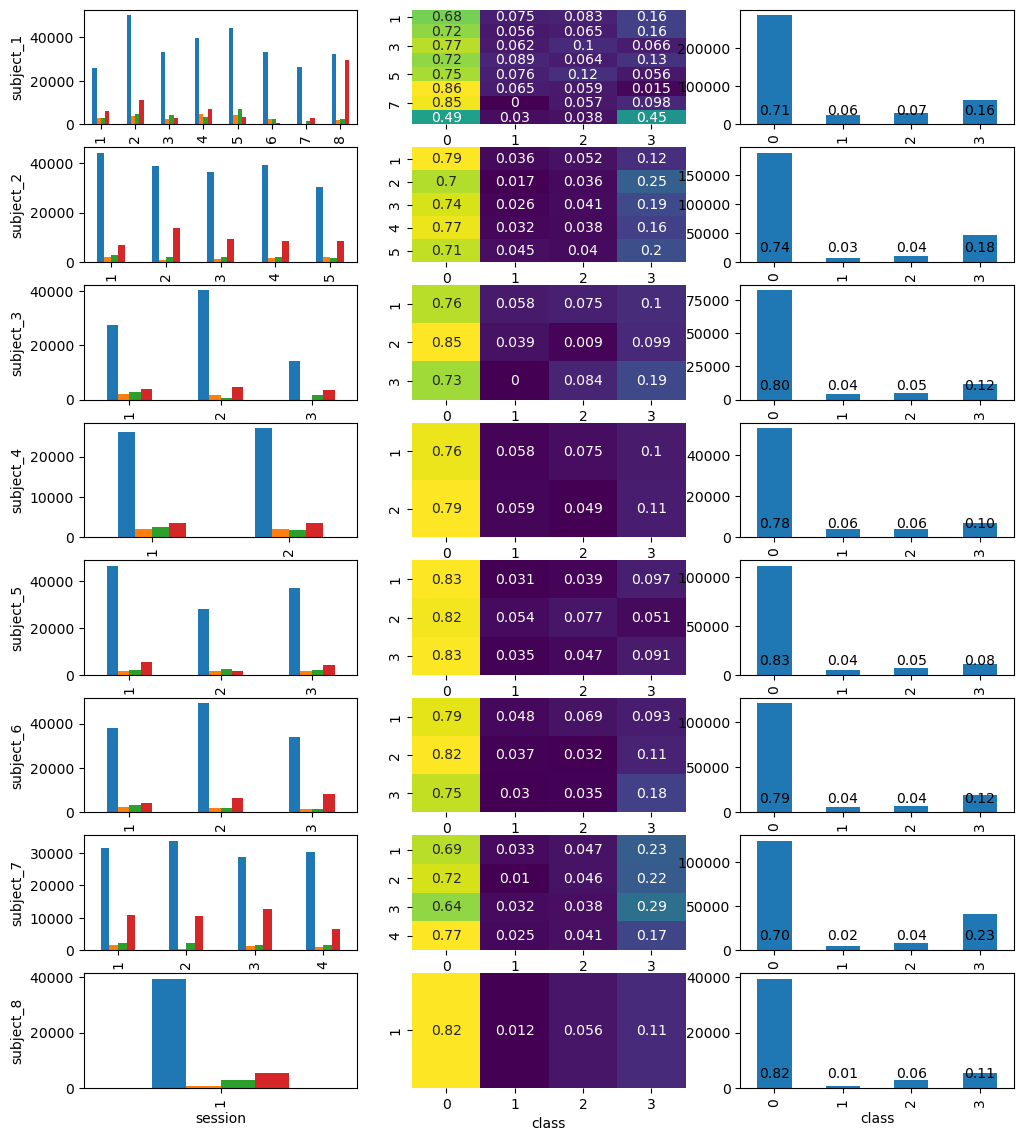

In [8]:
## Upsampled dataset
dctUpsPerSess = {}
dctUpsPerClass = {}

fig, ax = plt.subplots(figsize = (12, 14), nrows = 8, ncols = 3)
for ik, k in enumerate(dctUps.keys()):
    dummy = dctUps[k][['class', 'session']]
    dummy['class'] = dummy['class'].astype('category')
    table = pd.pivot_table(dummy, values='class', index='session', columns='class', aggfunc=len, fill_value=0)
    table.plot.bar(ax = ax[ik, 0], legend = False)
    
    perSess = table.copy()
    for i in perSess.index:
        perSess.loc[i, :] = perSess.loc[i, :].values/np.sum(perSess.loc[i, :].values)
    sns.heatmap(perSess, annot=True, cbar=False, cmap='viridis', ax = ax[ik, 1])
    ax[ik, 1].set_ylabel('')

    dctUpsPerSess[k] = perSess
    dctUpsPerClass[k] = table.sum(axis = 0)/table.sum().sum()

    # Add annotations
    table.sum().plot.bar(ax = ax[ik, 2], legend = False)
    for iv, v in enumerate(dctUpsPerClass[k]):
        ax[ik, 2].annotate(f"{v:.2f}", xy=(iv, 0), xytext=(0, 5), textcoords="offset points", 
                        ha='center', va='bottom', fontsize=10)

    ax[ik, 0].set_ylabel(k)


In [9]:
## count number of timesteps for each session and subject
dctCountUps = {f'subject_{k+1}':pd.DataFrame(index = range(1, 9), columns = range(0, 4), data = 0) for k in range(8)}
for k in dctUps.keys():
    dfs = dctUps[k]
    for s in dfs['session'].unique():
        dfss = dfs[dfs['session'] == s]
        aux = dfss['class'].value_counts().sort_index()
        dctCountUps[k].loc[s, aux.index] = aux.values

,0,1,2,3
1,26201,1984,2572,3552
2,27108,2048,1700,3620
3,0,0,0,0
4,0,0,0,0
5,0,0,0,0
6,0,0,0,0
7,0,0,0,0
8,0,0,0,0


In [58]:
dctCountBal['subject_4']

,0,1,2,3
1,3552,1984,2572,3552
2,3620,2048,1700,3620
3,0,0,0,0
4,0,0,0,0
5,0,0,0,0
6,0,0,0,0
7,0,0,0,0
8,0,0,0,0


In [10]:
## get the number of instances needed for each class to make the dataset balanced
## the first and second more frequents classes per session (and subject) are set to 'threshold' times
## the third class in case they are larger.
dctCountBal = countBalance(dctCountUps, 2)

In [62]:
## randomly select values to match the number of calues in dctCountBal
## some sessions are not balanced because are saved for testing
dctUpsBal = {}

testSessions = [(1,5), (2, 2), (3, 2), (4, 1), (5, 1), (6, 2), (7, 3)]
dctTest = {}

for k in dctUps.keys():
    dfk =  dctUps[k]
    out2 = []

    for s in dfk['session'].unique():

        tup = (int(k.split('_')[1]), s)
        dfks = dfk[dfk['session'] == s]
        
        if tup in testSessions:
            dctTest[k] = dfks
            print(f'{k} session {s} for testing')
        else:
            print(f'{k} session {s} for training')
            numberClaUps = dctCountUps[k].loc[s, :]
            numberClaBal = dctCountBal[k].loc[s, :]
            out = []

            for c in numberClaUps.index:
                dfksc = dfks[dfks['class'] == c]
                dfkscBal = dfksc.sample(numberClaBal.loc[c]).sort_index()
                out.append(dfkscBal)
            
            dfout = pd.concat(out).sort_index()
            out2.append(dfout)
        
    dctUpsBal[k] = pd.concat(out2)

subject_1 session 1 for training
subject_1 session 2 for training
subject_1 session 3 for training
subject_1 session 4 for training
subject_1 session 5 for testing
subject_1 session 6 for training
subject_1 session 7 for training
subject_1 session 8 for training
subject_2 session 1 for training
subject_2 session 2 for testing
subject_2 session 3 for training
subject_2 session 4 for training
subject_2 session 5 for training
subject_3 session 1 for training
subject_3 session 2 for testing
subject_3 session 3 for training
subject_4 session 1 for testing
subject_4 session 2 for training
subject_5 session 1 for testing
subject_5 session 2 for training
subject_5 session 3 for training
subject_6 session 1 for training
subject_6 session 2 for testing
subject_6 session 3 for training
subject_7 session 1 for training
subject_7 session 2 for training
subject_7 session 3 for testing
subject_7 session 4 for training
subject_8 session 1 for training


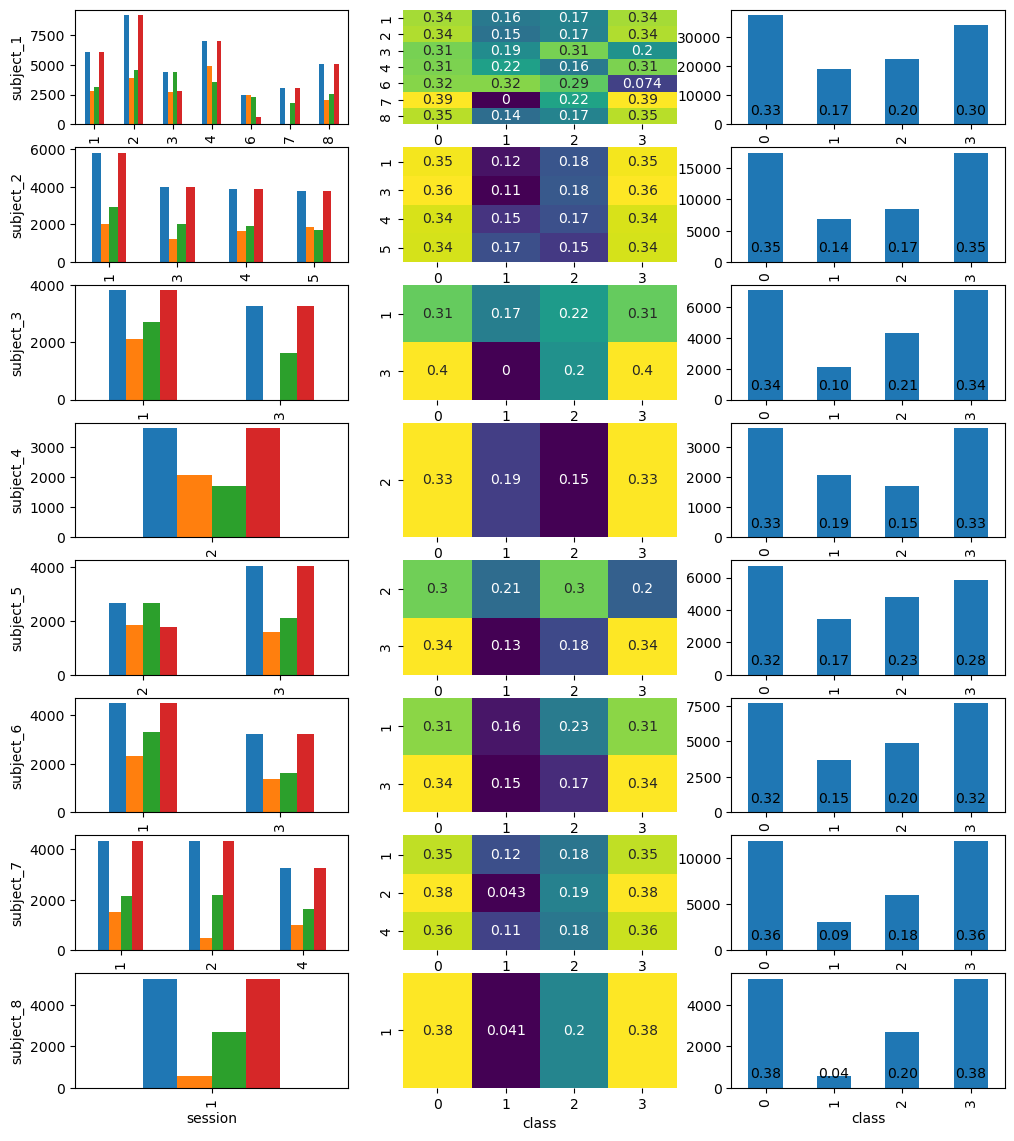

In [63]:
## Balanced dataset
dctUpsPerSess = {}
dctUpsPerClass = {}

fig, ax = plt.subplots(figsize = (12, 14), nrows = 8, ncols = 3)
for ik, k in enumerate(dctUpsBal.keys()):
    dummy = dctUpsBal[k][['class', 'session']]
    dummy['class'] = dummy['class'].astype('category')
    table = pd.pivot_table(dummy, values='class', index='session', columns='class', aggfunc=len, fill_value=0)
    table.plot.bar(ax = ax[ik, 0], legend = False)
    
    perSess = table.copy()
    for i in perSess.index:
        perSess.loc[i, :] = perSess.loc[i, :].values/np.sum(perSess.loc[i, :].values)
    sns.heatmap(perSess, annot=True, cbar=False, cmap='viridis', ax = ax[ik, 1])
    ax[ik, 1].set_ylabel('')

    dctUpsPerSess[k] = perSess
    dctUpsPerClass[k] = table.sum(axis = 0)/table.sum().sum()

    # Add annotations
    table.sum().plot.bar(ax = ax[ik, 2], legend = False)
    for iv, v in enumerate(dctUpsPerClass[k]):
        ax[ik, 2].annotate(f"{v:.2f}", xy=(iv, 0), xytext=(0, 5), textcoords="offset points", 
                        ha='center', va='bottom', fontsize=10)

    ax[ik, 0].set_ylabel(k)


In [67]:
## combined training a validation set
wlength = 75
overlapping = 50

dctSt = {}
for k in dctUpsBal.keys():
    df = dctUpsBal[k]
    list2 = []
    ## loop through sessions
    for s in df['session'].unique():
        dfs = df[df['session'] == s]
        for i in range(0, len(dfs) - overlapping, wlength - overlapping):
            dfss = dfs.iloc[i:i + wlength]
            dfssfft = pd.DataFrame(index = dfss.index, data = np.abs(np.fft.fft(dfss.iloc[:, :6])))
            dfss = pd.concat([dfss, dfssfft], axis = 1)
            dfssClass = dfss[['class']]
            dfss = dfss.drop(['session', 'time', 'class', 'class_time'], axis = 1)
            list1 = []
            for ic, c in enumerate(dfss.columns):
                dummy = list(dfss[c].quantile(np.arange(0, 1.1, 0.1)))
                list1.extend(dummy)
            list1.append(int(dfssClass['class'].mode().iloc[0]))
            list2.append(list1)
    dctSt[k] = pd.DataFrame(data = list2)

In [68]:
## Windowed test set. Extra column with the session is added, since later the prediction is done for each session separately.

wlength = 75
overlapping = 50

dctTestSt = {}
for k in dctTest.keys():
    df = dctTest[k]
    list2 = []
    ## loop through sessions
    for s in df['session'].unique():
        dfs = df[df['session'] == s]
        for i in range(0, len(dfs) - overlapping, wlength - overlapping):
            dfss = dfs.iloc[i:i + wlength]
            dfssfft = pd.DataFrame(index = dfss.index, data = np.abs(np.fft.fft(dfss.iloc[:, :6])))
            dfss = pd.concat([dfss, dfssfft], axis = 1)
            dfssClass = dfss[['class']]
            dfss = dfss.drop(['session', 'time', 'class', 'class_time'], axis = 1)
            list1 = []
            for ic, c in enumerate(dfss.columns):
                dummy = list(dfss[c].quantile(np.arange(0, 1.1, 0.1)))
                list1.extend(dummy)
            list1.append(int(dfssClass['class'].mode().iloc[0]))
            list1.append(s)
            list2.append(list1)
    dctTestSt[k] = pd.DataFrame(data = list2)

In [69]:
dftestSessions = pd.DataFrame(index = np.array(testSessions)[:, 0],
                              data = np.array(testSessions)[:, 1],
                              columns = ['session'])
dftestSessions

,session
1,5
2,2
3,2
4,1
5,1
6,2
7,3


In [71]:
dfsum_bal = []
for key in dctCountBal.keys():
    dfaux = dctCountBal[key].copy()
    
    ik = int(key.split('_')[1])
    
    if ik != 8:
        ise = dftestSessions.loc[ik, 'session']
        dfaux.loc[ise, :] = [0, 0, 0, 0]

    dfsum_bal.append(dfaux.sum())

dfsum_bal = pd.DataFrame(index = dctCountBal.keys(), columns = dctCountBal['subject_1'].columns, data = dfsum_bal)
dfsum_bal
# weights_bal = (dfsum_bal.sum()/dfsum_bal.sum().sum()).values
# print(weights_bal)

,0,1,2,3
subject_1,37384,18868,22316,33880
subject_2,17464,6832,8528,17464
subject_3,7092,2112,4352,7092
subject_4,3620,2048,1700,3620
subject_5,6736,3440,4800,5836
subject_6,7680,3676,4904,7680
subject_7,11896,3008,5948,11896
subject_8,5288,572,2712,5288


## Different models leaving different subjects out. FFT of features included

In [72]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(in_features = 132, out_features = 132*4)
    self.bn1 = nn.BatchNorm1d(num_features = 132*4)
    self.fc2 = nn.Linear(in_features = 132*4, out_features = 132*8)
    self.bn2 = nn.BatchNorm1d(num_features = 132*8)
    self.fc3 = nn.Linear(in_features = 132*8, out_features = 132*4)
    self.bn3 = nn.BatchNorm1d(num_features = 132*4)
    self.fc4 = nn.Linear(in_features = 132*4, out_features = 132*2)
    self.bn4 = nn.BatchNorm1d(num_features = 132*2)
    self.fc5 = nn.Linear(in_features = 132*2, out_features = 132)
    self.bn5 = nn.BatchNorm1d(num_features = 132)
    self.fc6 = nn.Linear(in_features = 132, out_features = 66)
    self.bn6 = nn.BatchNorm1d(num_features = 66)
    self.fc7 = nn.Linear(in_features = 66, out_features = 32)
    self.bn7 = nn.BatchNorm1d(num_features = 32)
    self.fc8 = nn.Linear(in_features = 32, out_features = 4)
    self.dout = nn.Dropout(p=0.4)

  def forward(self, x):
    x = self.fc1(x)
    x = F.relu(x)
    x = self.bn1(x)
    x = self.dout(x)

    x = self.fc2(x)
    x = F.relu(x)
    x = self.bn2(x)
    x = self.dout(x)

    x = self.fc3(x)
    x = F.relu(x)
    x = self.bn3(x)
    x = self.dout(x)

    x = self.fc4(x)
    x = F.relu(x)
    x = self.bn4(x)
    x = self.dout(x)

    x = self.fc5(x)
    x = F.relu(x)
    x = self.bn5(x)
    x = self.dout(x)

    x = self.fc6(x)
    x = F.relu(x)
    x = self.bn6(x)
    x = self.dout(x)
    
    x = self.fc7(x)
    x = F.relu(x)
    x = self.bn7(x)
    x = self.dout(x)

    x = self.fc8(x)
    x = F.softmax(x, dim = 1)

    return x

In [82]:
# Creating a wrapper so we have the same interface for all the methods
class NetWrapper:
  def __init__(self, epochs, lrate, dev, w):
    self.model = Net()
    if w is not None:
      self.loss = nn.CrossEntropyLoss(w)
    else:
      self.loss = nn.CrossEntropyLoss()
      
    self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lrate)
    self.device = dev
    self.model.to(self.device)
    self.epochs = epochs
    self.history = {'train_loss': [], 'test_loss': [], 
                    'train_f1': [], 'test_f1': []}
    self.min_loss = np.inf
    self.min_accu = 0
    self.best_weights = None

  def fit(self, X_train, Y_train, X_test, Y_test):
    
    for t in range(self.epochs):

        ########### Training
        self.model.train()
        self.optimizer.zero_grad()
        X_train2 = torch.from_numpy(X_train).to(torch.float32).to(device)
        Y_pred = self.model(X_train2).to(torch.float32)
        ## compute loss
        Y_train2 = torch.from_numpy(Y_train).to(device)
        Y_train2 = torch.squeeze(Y_train2, 1)
        loss = self.loss(Y_pred, Y_train2)
        loss_val = float(loss.cpu().detach().numpy())
        f1_tr = f1_score(Y_pred.cpu().detach().numpy().argmax(1).reshape(-1), 
                         Y_train2.cpu().detach().numpy(), average='macro')
        ## backward propagation
        loss.backward()
        self.optimizer.step()
        self.history[r'train_loss'].append(loss_val)
        self.history[r'train_f1'].append(f1_tr)

        ########### Evaluation
        self.model.eval()
        X_test2 = torch.from_numpy(X_test).to(torch.float32).to(device)
        Y_pred = self.model(X_test2).to(torch.float32)
        ## compute loss
        Y_test2 = torch.from_numpy(Y_test).view(-1).to(device)
        loss = self.loss(Y_pred, Y_test2)
        loss_val = float(loss.cpu().detach().numpy())
        f1_vl = f1_score(Y_pred.cpu().detach().numpy().argmax(1).reshape(-1), 
                         Y_test2.cpu().detach().numpy(), average='macro')
        self.history[r'test_loss'].append(loss_val)
        self.history[r'test_f1'].append(f1_vl)

        if f1_vl > self.min_accu:
          self.min_acu = f1_vl
          self.best_weights = copy.deepcopy(self.model.state_dict())

        if t%500 == 0:
          a = self.history[f'train_f1'][t]
          b = self.history[f'test_f1'][t]
        
          print(f'Epoch {t}/{self.epochs}. Training f1: {a:0.3f} - Validation f1: {b:0.3f}')
    
    dfhist = pd.DataFrame.from_dict(self.history)

    return dfhist, self.min_loss, self.best_weights

  def predict(self, X):
    X = torch.from_numpy(X).float().to(self.device)
    # print(X)
    pred = self.model(X)
    pred = pred.cpu().detach().numpy()

    return pred

In [76]:
dfAll = []
l = 0
for k in dctSt.keys():
    aux = dctSt[k]
    aux['subject'] = [k]*len(aux)
    aux.index = range(l, l + len(aux))
    dfAll.append(aux)
    l += len(aux)
dfAll = pd.concat(dfAll, axis = 0)

scaler = StandardScaler()
dfX_sc = pd.DataFrame(scaler.fit_transform(dfAll.iloc[:, :-2]))
dfX_sc['subject'] = dfAll['subject'].values
dfy = dfAll.iloc[:, [-2]]

************************* Leaving subject_1 out *************************
Epoch 0/5000. Training f1: 0.231 - Validation f1: 0.074
Epoch 500/5000. Training f1: 0.950 - Validation f1: 0.837
Epoch 1000/5000. Training f1: 0.980 - Validation f1: 0.823
Epoch 1500/5000. Training f1: 0.988 - Validation f1: 0.820
Epoch 2000/5000. Training f1: 0.991 - Validation f1: 0.821
Epoch 2500/5000. Training f1: 0.994 - Validation f1: 0.821
Epoch 3000/5000. Training f1: 0.995 - Validation f1: 0.820
Epoch 3500/5000. Training f1: 0.995 - Validation f1: 0.822
Epoch 4000/5000. Training f1: 0.996 - Validation f1: 0.818
Epoch 4500/5000. Training f1: 0.995 - Validation f1: 0.818
************************* Leaving subject_2 out *************************
Epoch 0/5000. Training f1: 0.255 - Validation f1: 0.062
Epoch 500/5000. Training f1: 0.958 - Validation f1: 0.756
Epoch 1000/5000. Training f1: 0.982 - Validation f1: 0.761
Epoch 1500/5000. Training f1: 0.988 - Validation f1: 0.757
Epoch 2000/5000. Training f1: 0.99

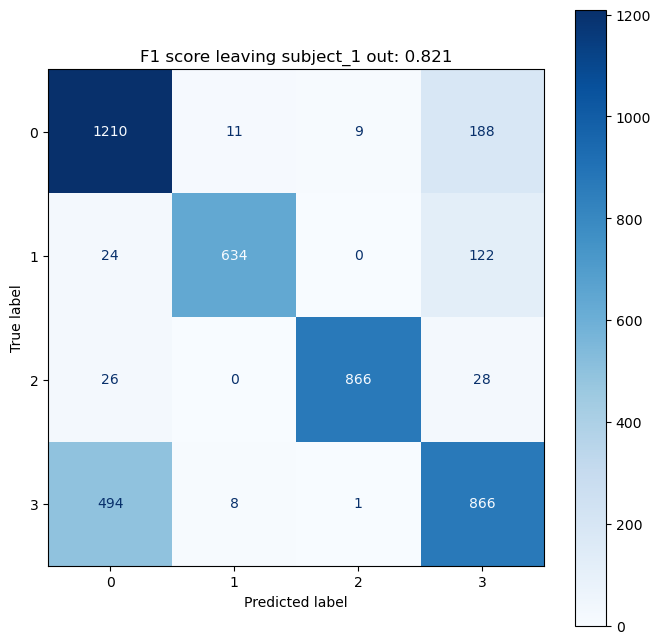

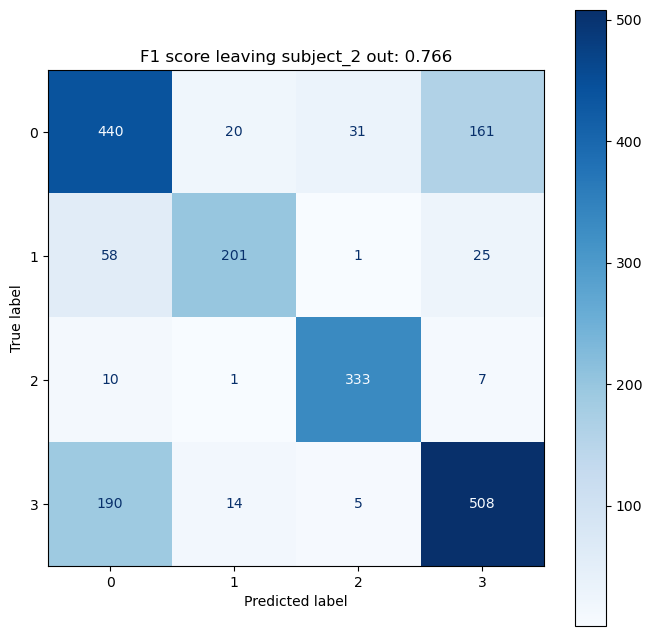

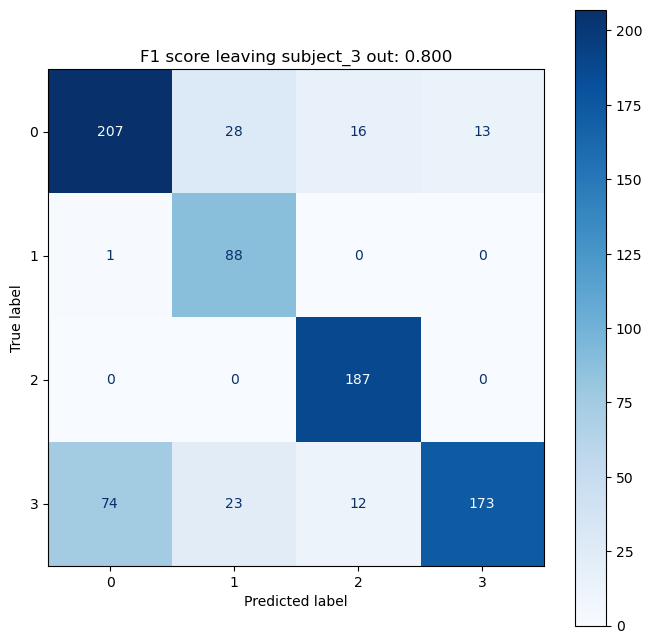

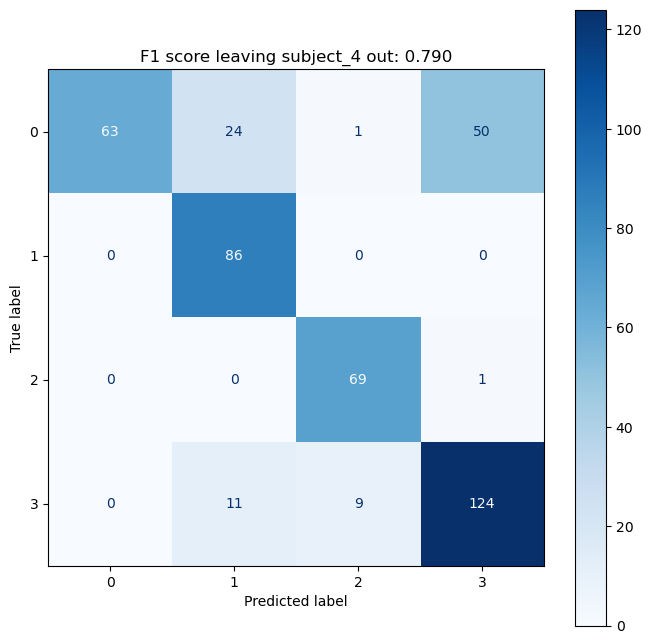

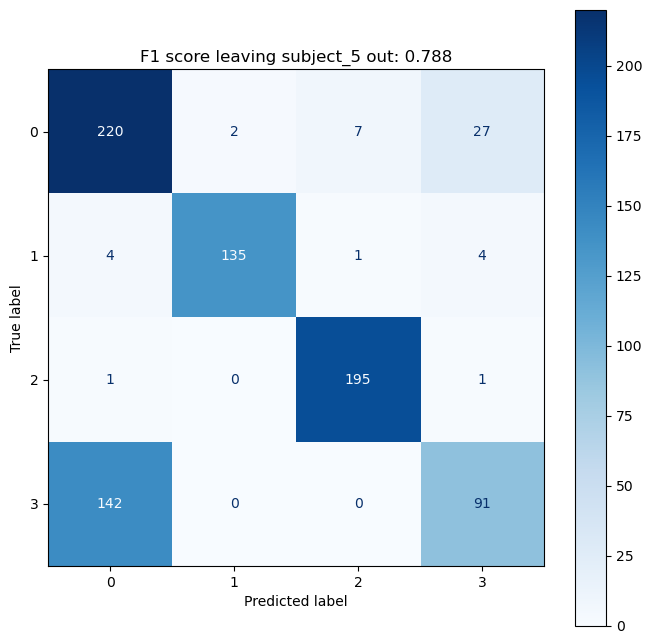

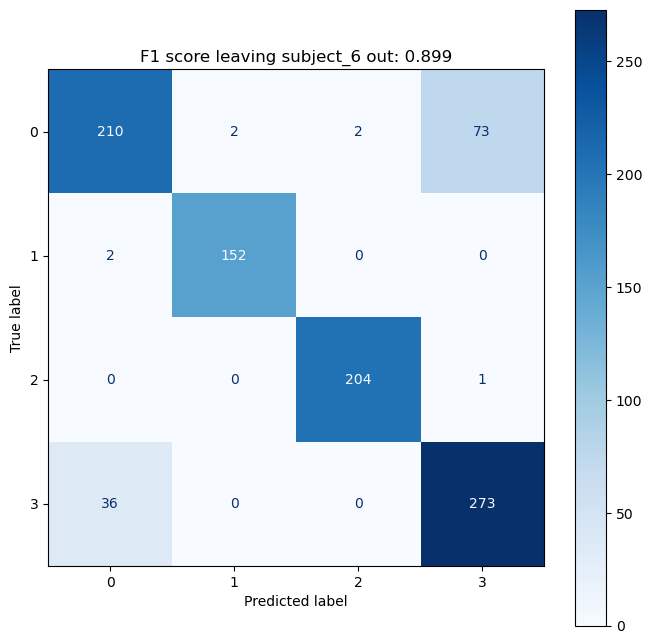

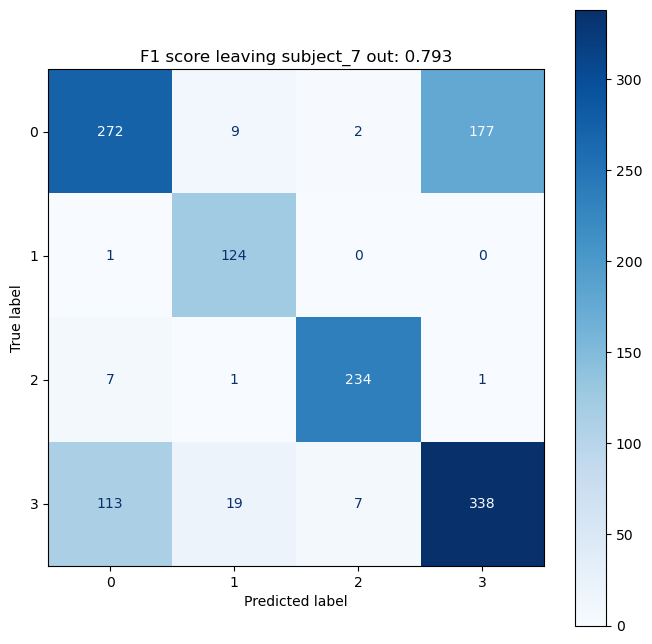

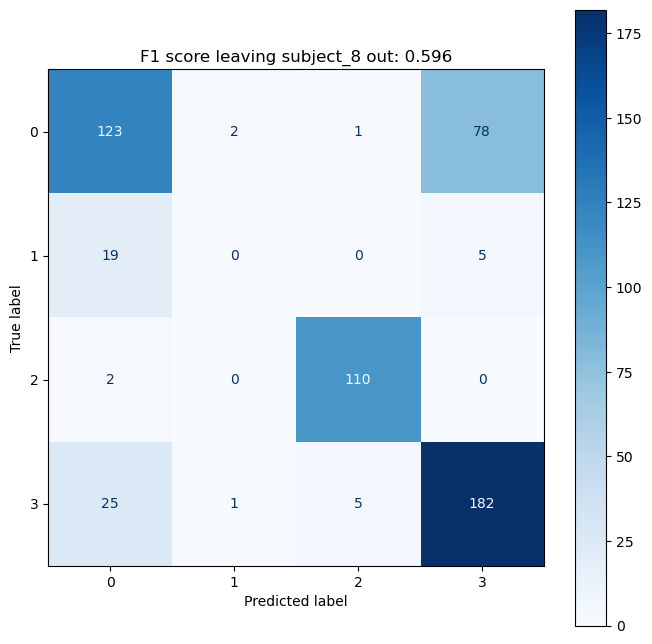

In [83]:
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learning_rate = 1e-4

list_dfhist, list_minLoss, list_bestModel = [], [], []

for i in range(1, 9):

    keyval = f'subject_{i}'
    print(f'************************* Leaving {keyval} out *************************')

    dfsum_bal2 = dfsum_bal.drop([keyval], axis = 0)
    weights_bal = torch.from_numpy((dfsum_bal2.sum()/dfsum_bal2.sum().sum()).values).to(torch.float32)

    dfXtr = dfX_sc[dfX_sc['subject'] != keyval]
    dfytr = dfy.loc[dfXtr.index, :]

    dfXvl = dfX_sc[dfX_sc['subject'] == keyval]
    dfyvl = dfy.loc[dfXvl.index, :]

    Xtr = dfXtr.iloc[:, :-1].values.astype(float)
    ytr = dfytr.values

    Xvl = dfXvl.iloc[:, :-1].values.astype(float)
    yvl = dfyvl.values

    net = NetWrapper(5_000, learning_rate, device, weights_bal.to(device))
    dfhist, minLoss, bestModel = net.fit(Xtr, ytr, Xvl, yvl)
    list_dfhist.append(dfhist)
    list_minLoss.append(minLoss)
    list_bestModel.append(bestModel)

    pred = net.predict(Xvl).argmax(axis = 1)
    m = confusion_matrix(yvl, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=m)
    fig, ax = plt.subplots(figsize = (8, 8))
    disp.plot(ax = ax,  cmap = plt.cm.Blues)
    ax.set_title(f"F1 score leaving {keyval} out: {f1_score(pred, yvl, average='macro'):0.3f}")

In [84]:
dfTest = []
i = 0
for k in dctTestSt.keys():
    aux = dctTestSt[k]
    aux.index = range(i, i + len(aux))
    i += len(aux)
    dfTest.append(aux)
dfTest = pd.concat(dfTest, axis = 0)

Xtest = dfTest.iloc[:, :-2]
Xtest_sc = scaler.transform(Xtest)
ytest = dfTest.iloc[:, -2].values

In [17]:
with open('scaler_model09.pkl', 'wb') as fout:
    pickle.dump(scaler, fout)

In [25]:
# # models = []
# for imod, mod in enumerate(list_bestModel):
#     # create a new instance of the model
#     model = Net()
#     # load saved weights
#     model.load_state_dict(mod)
#     wrapper = NetWrapper(epochs=0, lrate=0, dev=device, w=None)
#     wrapper.model = model.to(device)
#     # put the model in evaluation mode
#     pred = wrapper.predict(Xtest_sc).argmax(axis = 1)
    
#     m = confusion_matrix(ytest, pred)
#     disp = ConfusionMatrixDisplay(confusion_matrix=m)
#     fig, ax = plt.subplots(figsize = (8, 8))
#     disp.plot(ax = ax,  cmap = plt.cm.Blues)
#     ax.set_title(f"F1 score leaving subject {imod + 1} out: {f1_score(pred, ytest, average='macro'):0.3f} - Test set")

Text(0.5, 1.0, 'F1 score with averaged probs: 0.868 - Test set')

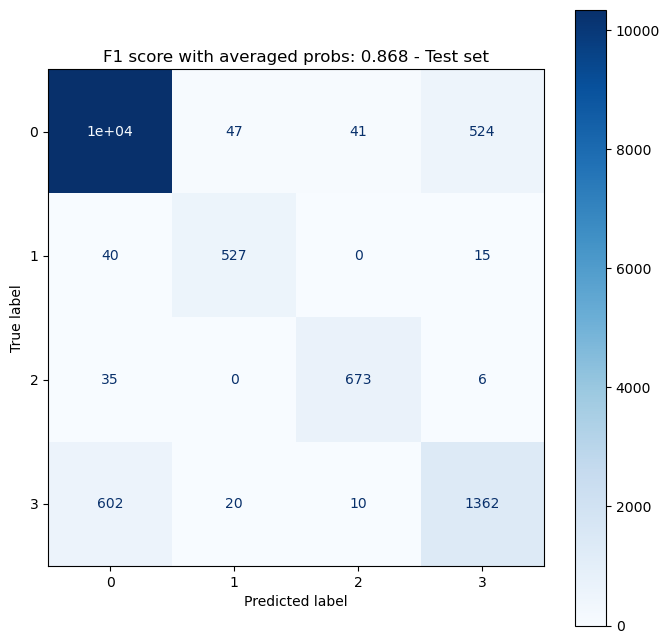

In [85]:
# average probabilities
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pin = Path(r'/home/tomas/github/ECE542_NCSU_projC')
list_preds = []
list_bestModel = [torch.load(pin/x) for x in sorted([y for y in os.listdir(pin) if y.startswith('model09_subject')])]
for imod, mod in enumerate(list_bestModel):
    # create a new instance of the model
    model = Net()
    # load saved weights
    model.load_state_dict(mod)
    wrapper = NetWrapper(epochs=0, lrate=0, dev=device, w=None)
    wrapper.model = model.to(device)
    # put the model in evaluation mode
    pred = wrapper.predict(Xtest_sc)
    list_preds.append(pred)
arr_preds = np.array(list_preds)

arr_preds_mean = np.mean(arr_preds, axis = 0)
preds_mean = np.argmax(arr_preds_mean, axis = 1)

m = confusion_matrix(ytest, preds_mean)
disp = ConfusionMatrixDisplay(confusion_matrix=m)
fig, ax = plt.subplots(figsize = (8, 8))
disp.plot(ax = ax,  cmap = plt.cm.Blues)
ax.set_title(f"F1 score with averaged probs: {f1_score(preds_mean, ytest, average='macro'):0.3f} - Test set")

In [131]:
# for imod, mod in enumerate(list_bestModel):
#     torch.save(mod, f'model09_subject_{imod+1}out_1e4epochs.pt')

In [86]:
# Predict session by session to then unwindow the predictions
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pin = Path(r'/home/tomas/github/ECE542_NCSU_projC')
list_bestModel = [torch.load(pin/x) for x in sorted([y for y in os.listdir(pin) if y.startswith('model09_subject')])]

dctPredClass = {}
dctPredProbs = {}

for k in dctTestSt.keys():
    print(k)
    dfTestK = dctTestSt[k]

    dfTestFullK = dctTest[k]

    for s in dfTestK.iloc[:, -1].unique():
        print(s)
        dfTestKs = dfTestK[dfTestK[133] == s]

        dfTestFullK = dfTestFullK[dfTestFullK['session'] == s]

        list_preds = []
        for imod, mod in enumerate(list_bestModel):
            model = Net()
            model.load_state_dict(mod)
            wrapper = NetWrapper(epochs=0, lrate=0, dev=device, w=None)
            wrapper.model = model.to(device)
            pred = wrapper.predict(scaler.transform(dfTestKs.iloc[:, :-2]))
            list_preds.append(pred)
        arr_preds = np.array(list_preds)
        mean_arr_preds = np.mean(arr_preds, axis = 0)
        predictedClass = np.argmax(mean_arr_preds, axis = 1)
        predictedProbs = np.max(mean_arr_preds, axis = 1)

        dctPredClass[f'{k}_session_{s}'] = predictedClass
        dctPredProbs[f'{k}_session_{s}'] = predictedProbs

subject_1
5
subject_2
2
subject_3
2
subject_4
1
subject_5
1
subject_6
2
subject_7
3


In [87]:
wlength = 75
overlapping = 50
aux = wlength - overlapping

arrClassAll = []
trueClassAll = []

for k in dctPredProbs.keys():
    print(k)
    subj = k.split('_sess')[0]
    sess = int(k.split('_')[-1])

    dfTestFullK = dctTest[subj]

    for sess in dfTestFullK['session'].unique():
        print(sess)
        dfTestFullKs = dfTestFullK[dfTestFullK['session'] == sess]
        
        #dfAuxProbs = pd.DataFrame(index = range(len(dfTestFullK)), columns = range(len(predictedClass)), data = -1)
        #dfAuxClass = dfAuxProbs.copy()
        arrProbs = np.full((len(dfTestFullK), len(predictedClass)), np.nan)
        arrClass = arrProbs.copy()
        
        for icol in range(arrProbs.shape[1]):
            if icol != arrProbs.shape[1] - 1:
                arrProbs[icol*aux: icol*aux + wlength, icol] = predictedProbs[icol]
                arrClass[icol*aux: icol*aux + wlength, icol] = predictedClass[icol]
            else:
                arrProbs[icol*aux:, icol] = [predictedProbs[icol]] * len(arrProbs[icol*aux:, -1])
                arrClass[icol*aux:, icol] = [predictedClass[icol]] * len(arrClass[icol*aux:, -1])

        colMaxProb = np.nanargmax(arrProbs, axis = 1)
        classMaxProb = [arrClass[i, colMaxProb[i]] for i in range(len(arrClass))]#arrClass[np.arange(len(dfTestFullKs), colMaxProb)]
        arrClassAll.extend(classMaxProb)

subject_1_session_5
5
subject_2_session_2
2
subject_3_session_2
2
subject_4_session_1
1
subject_5_session_1
1
subject_6_session_2
2
subject_7_session_3
3


In [88]:
len(arrClassAll)

356323

In [89]:
dfTestAll = []
for k in dctTest.keys():
    aux = dctTest[k]
    aux.index = range(i, i + len(aux))
    i += len(aux)
    dfTestAll.append(aux)
dfTestAll = pd.concat(dfTestAll, axis = 0)
print(len(dfTestAll))

356323


Text(0.5, 1.0, 'F1 score with averaged probs: 0.353 - Test set')

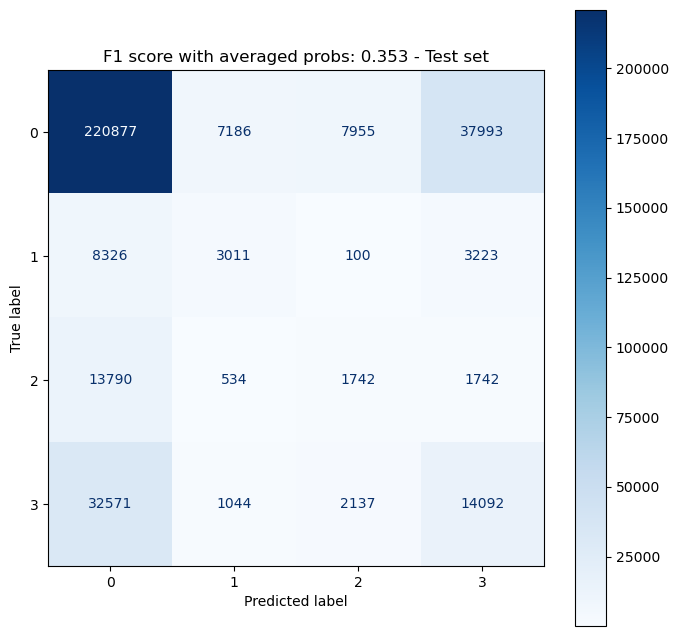

In [90]:
m = confusion_matrix(dfTestAll['class'].values, arrClassAll)
disp = ConfusionMatrixDisplay(confusion_matrix=m)
fig, ax = plt.subplots(figsize = (8, 8))
disp.plot(ax = ax,  cmap = plt.cm.Blues)
ax.set_title(f"F1 score with averaged probs: {f1_score(arrClassAll, dfTestAll['class'].values, average='macro'):0.3f} - Test set")

In [36]:
# arr_preds_max = np.max(arr_preds, axis = 0)
# preds_max = np.argmax(arr_preds_max, axis = 1)
# m = confusion_matrix(ytest, preds_mean)
# disp = ConfusionMatrixDisplay(confusion_matrix=m)
# fig, ax = plt.subplots(figsize = (8, 8))
# disp.plot(ax = ax,  cmap = plt.cm.Blues)
# ax.set_title(f"F1 score taking max prob: {f1_score(preds_max, ytest, average='macro'):0.3f} - Test set")

### Predict for the grading test set

In [24]:
def read_data_testing(pathin):
    ''''''
    # Define the header names for the 'x' CSV files
    x_header = ["accx", "accy", "accz", "gyrox", "gyroy", "gyroz"]
    # Define the header names for the 'x_time' CSV files
    x_time_header = ["seconds"]

    # Define the header names for the 'y' CSV files
    # y_header = ["class"]

    # Define the header names for the 'y_time' CSV files
    y_time_header = ["seconds"]

    # Create an empty list to store the dataframes
    dct = {}

    filesAll = [x for x in os.listdir(pathin) if x.endswith('.csv')]

    nSubjects = 4

    for i in range(9, 13):
        files = sorted([x for x in filesAll if x.startswith(f'subject_{i:03d}')])
        nSessions = int(len(files)/3) ## 4 files per session
        
        xdataAll = []
        ydataAll = []

        for j in range(nSessions):
            xdata = pd.read_csv(pathin/f'subject_{i:03d}_{j+1:02d}__x.csv', header = None, names = x_header)
            xdata['session'] = [j+1]*len(xdata)
            xtime = pd.read_csv(pathin/f'subject_{i:03d}_{j+1:02d}__x_time.csv', header = None, names = x_time_header)
            xdata['time'] = xtime['seconds'].values
            xdataAll.append(xdata)

            # ydata = pd.read_csv(pathin/f'subject_{i+1:03d}_{j+1:02d}__y.csv', header = None, names = y_header)
            # ydata['session'] = [j+1]*len(ydata)
            ytime = pd.read_csv(pathin/f'subject_{i:03d}_{j+1:02d}__y_time.csv', header = None, names = y_time_header)
            # ydata['time'] = ytime['seconds'].values
            ydataAll.append(ytime)

        dfx = pd.concat(xdataAll)
        dfx.index = range(len(dfx))
        dfy = pd.concat(ydataAll)
        dfy.index = range(len(dfy))

        dct[f'subject_{i}_x'] = dfx
        dct[f'subject_{i}_y'] = dfy
    return dct

In [25]:
## read data as a dictionary with each subject as a different key
## the sessions are included as a column in each dataframe
pathTest = Path(pin/'TestData')
dctTestData = read_data_testing(pathTest)

In [26]:
dctTestData.keys()

dict_keys(['subject_9_x', 'subject_9_y', 'subject_10_x', 'subject_10_y', 'subject_11_x', 'subject_11_y', 'subject_12_x', 'subject_12_y'])

In [27]:
dctTestData['subject_9_y']

,seconds
0,0.02
1,0.12
2,0.22
3,0.32
4,0.42
...,...
9493,949.32
9494,949.42
9495,949.52
9496,949.62


In [28]:
## duplicate upsampled dictionary but with flags for the windows of each class in each session
## for each subject

wlength = 75
overlapping = 50

dctGradingSt = {}
for k in dctTestData.keys():

    if k.endswith('_x'):
        df = dctTestData[k]
        list2 = []
        ## loop through sessions
        for s in df['session'].unique():
            dfs = df[df['session'] == s]
            for i in range(0, len(dfs) - overlapping, wlength - overlapping):
                dfss = dfs.iloc[i:i + wlength]
                dfssfft = pd.DataFrame(index = dfss.index, data = np.abs(np.fft.fft(dfss.iloc[:, :6])))
                dfss = pd.concat([dfss, dfssfft], axis = 1)
                # dfssClass = dfss[['class']]
                dfss = dfss.drop(['session', 'time'], axis = 1)
                list1 = []
                for ic, c in enumerate(dfss.columns):
                    dummy = list(dfss[c].quantile(np.arange(0, 1.1, 0.1)))
                    list1.extend(dummy)
                list1.append(s)
                list2.append(list1)
        dctGradingSt[k] = pd.DataFrame(data = list2)

In [26]:
# dfGrading = []
# i = 0
# for k in dctGradingSt.keys():
#     aux = dctGradingSt[k]
#     aux.index = range(i, i + len(aux))
#     i += len(aux)
#     dfGrading.append(aux)
# dfGrading = pd.concat(dfGrading, axis = 0)

# Xgrad_sc = scaler.transform(dfGrading)

In [29]:
# Predict session by session to then unwindow the predictions
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pin = Path(r'/home/tomas/github/ECE542_NCSU_projC')
list_bestModel = [torch.load(pin/x) for x in sorted([y for y in os.listdir(pin) if y.startswith('model09_subject')])]

dctPredClass = {}
dctPredProbs = {}

for k in dctGradingSt.keys():
    print(k)
    dfTestK = dctGradingSt[k]

    dfTestFullK = dctTestData[k]

    for s in dfTestK.iloc[:, -1].unique():
        print(s)
        dfTestKs = dfTestK[dfTestK[132] == s]

        dfTestFullK = dfTestFullK[dfTestFullK['session'] == s]

        list_preds = []
        for imod, mod in enumerate(list_bestModel):
            model = Net()
            model.load_state_dict(mod)
            wrapper = NetWrapper(epochs=0, lrate=0, dev=device, w=None)
            wrapper.model = model.to(device)
            pred = wrapper.predict(scaler.transform(dfTestKs.iloc[:, :-1]))
            list_preds.append(pred)
        arr_preds = np.array(list_preds)
        mean_arr_preds = np.mean(arr_preds, axis = 0)
        predictedClass = np.argmax(mean_arr_preds, axis = 1)
        predictedProbs = np.max(mean_arr_preds, axis = 1)

        dctPredClass[f'{k}_session_{s}'] = predictedClass
        dctPredProbs[f'{k}_session_{s}'] = predictedProbs

subject_9_x
1
subject_10_x
1
subject_11_x
1
subject_12_x
1


In [30]:
wlength = 75
overlapping = 50
aux = wlength - overlapping

arrClassAll = []
trueClassAll = []

for k in dctPredProbs.keys():
    print(k)
    subj = k.split('_sess')[0]
    sess = int(k.split('_')[-1])

    dfTestFullK = dctTestData[subj]

    for sess in dfTestFullK['session'].unique():
        print(sess)
        dfTestFullKs = dfTestFullK[dfTestFullK['session'] == sess]
        
        #dfAuxProbs = pd.DataFrame(index = range(len(dfTestFullK)), columns = range(len(predictedClass)), data = -1)
        #dfAuxClass = dfAuxProbs.copy()
        arrProbs = np.full((len(dfTestFullK), len(predictedClass)), np.nan)
        arrClass = arrProbs.copy()
        
        for icol in range(arrProbs.shape[1]):
            if icol != arrProbs.shape[1] - 1:
                arrProbs[icol*aux: icol*aux + wlength, icol] = predictedProbs[icol]
                arrClass[icol*aux: icol*aux + wlength, icol] = predictedClass[icol]
            else:
                arrProbs[icol*aux:, icol] = [predictedProbs[icol]] * len(arrProbs[icol*aux:, -1])
                arrClass[icol*aux:, icol] = [predictedClass[icol]] * len(arrClass[icol*aux:, -1])

        colMaxProb = np.nanargmax(arrProbs, axis = 1)
        classMaxProb = [arrClass[i, colMaxProb[i]] for i in range(len(arrClass))]#arrClass[np.arange(len(dfTestFullKs), colMaxProb)]
        arrClassAll.append(classMaxProb)

subject_9_x_session_1
1
subject_10_x_session_1
1
subject_11_x_session_1
1
subject_12_x_session_1
1


In [33]:
pout = Path(r'/home/tomas/github/ECE542_NCSU_projC/resultsGrading')
for k, dummy in zip(dctPredProbs.keys(), arrClassAll):
    print(k)
    s = k.split('_')[1]
    aux = k.split('_session')[0]

    dfdummy = pd.DataFrame({'predClass': dummy, 'time': dctTestData[aux]['time']})
    dfCorrTime = dctTestData[f'subject_{s}_y']
    distm = cdist(dfCorrTime['seconds'].values[:, None], dfdummy['time'].values[:, None])
    dfdummy = dfdummy.loc[distm.argmin(axis = 1), 'predClass'].astype(int)
    del distm
    dfdummy.to_csv(pout/f'subject_{int(s):03d}_01__y.csv', header = None, index = False)

subject_9_x_session_1
subject_10_x_session_1
subject_11_x_session_1
subject_12_x_session_1


In [27]:
# average probabilities
list_preds = []
for imod, mod in enumerate(list_bestModel):
    # create a new instance of the model
    model = Net()
    # load saved weights
    model.load_state_dict(mod)
    wrapper = NetWrapper(epochs=0, lrate=0, dev=device, w=None)
    wrapper.model = model.to(device)
    # put the model in evaluation mode
    pred = wrapper.predict(Xgrad_sc)
    list_preds.append(pred)
arr_preds = np.array(list_preds)

arr_preds_mean = np.mean(arr_preds, axis = 0)
preds_mean = np.argmax(arr_preds_mean, axis = 1)
preds_mean_probs = np.max(arr_preds_mean, axis = 1)

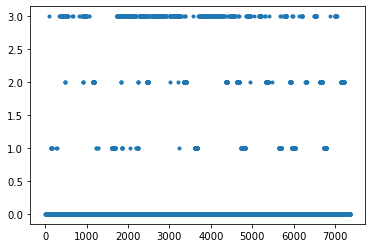

In [28]:
plt.plot(preds_mean, '.')

In [82]:
dele = dctData['subject_1_y']
dele = dele[dele['session'] == 1]

In [83]:
dele

,class,session,time
0,0,1,0.02
1,0,1,0.12
2,0,1,0.22
3,0,1,0.32
4,0,1,0.42
...,...,...,...
9468,0,1,946.82
9469,0,1,946.92
9470,0,1,947.02
9471,0,1,947.12
